In [1]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
#load the dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Training_images shape:  (60000, 28, 28)
How many test samples are there:  10000
Training labels shape:  (60000,)
One label example:  9


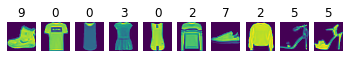

In [3]:
#Visualization
print("Training_images shape: ", training_images.shape)
print("How many test samples are there: ", test_images.shape[0])
print("Training labels shape: ", training_labels.shape)
print("One label example: ", training_labels[0])

#Visualize the images
fig, ax = plt.subplots(1,10)

for i in range(10):
  ax[i].imshow(training_images[i])
  ax[i].set_title(training_labels[i])
  ax[i].axis("off")




## Preprocessing

In [4]:
#perform necessary preprocessing steps
#for our autoencoder we do not need the labels

#normalizing the images
training_images = tf.data.Dataset.from_tensor_slices(training_images)
training_images = training_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
training_images = training_images.map(lambda img: img/255)

#Prepare the dataset
#this includes dividing the dataset into batches
training_data = training_images.batch(64)
training_data = training_data.shuffle(buffer_size= 64)
training_data = training_data.prefetch(16)


test_images_tsne = test_images[:1000]
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_images = test_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images = test_images.map(lambda img: img/255)

test_data = test_images.batch(20)
test_data = test_data.shuffle(buffer_size= 20)
test_data = test_data.prefetch(10)


test_images_tsne = tf.data.Dataset.from_tensor_slices(test_images_tsne)
test_images_tsne = test_images_tsne.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images_tsne = test_images_tsne.map(lambda img: img/255)
test_images_tsne = test_images_tsne.batch(20).prefetch(10)

test_labels = test_labels[:1000]

## 1. Convolutional Autoencoder

### 1.1. Encoder

In [5]:
class EncBlock(tf.keras.layers.Layer):
  def __init__(self, number_filters):
    super(EncBlock, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters = number_filters, activation = None, kernel_size = 3, padding = 'same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(strides = (2,2))

  def call(self, input_x, training):
    x = self.conv(input_x)
    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.pool(x)

    return x

class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    #self.dense_layer = tf.keras.layers.Dense(units = (28*28), activation = tf.keras.activations.relu)
    self.block1 = EncBlock(32)
    self.block2 = EncBlock(16)

    self.flatten = tf.keras.layers.Flatten()
    self.encoding_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)

  def call(self, input_x, training):

    x = self.block1(input_x, training)
    x = self.block2(x, training)
    x = self.flatten(x)
    x = self.encoding_layer(x)

    return x


### 1.2. Decoder

In [6]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    #firstly restore dimensionality with a dense_layer
    
    self.dense_layer = tf.keras.layers.Dense(units = (7*7*32), activation = tf.keras.activations.relu)
    self.reshape = tf.keras.layers.Reshape((7,7,32))
    self.ConvT_1 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.relu1 = tf.keras.layers.ReLU()
    self.ConvT_2 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.relu2 = tf.keras.layers.ReLU()
    self.output_layer = tf.keras.layers.Conv2D(filters=1, padding = 'same', kernel_size = 3, activation= tf.keras.activations.sigmoid)

  def call(self, input_x, training):
    x = self.dense_layer(input_x)
    x = self.reshape(x)
    x = self.ConvT_1(x)
    x = self.batch_norm1(x, training)
    x = self.relu1(x)
    x = self.ConvT_2(x)
    x = self.batch_norm2(x, training)
    x = self.relu2(x)
    x = self.output_layer(x)

    return x

### 1.3. Autoencoder

In [7]:
class ConvoAE(tf.keras.Model):
  def __init__(self):
    super(ConvoAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def call(self, input_x, training):
    x = self.encoder(input_x, training)
    x = self.decoder(x, training)

    return x

## Training

In [8]:
def train_step(model, samples, noisy_samples, loss_function, optimizer, training= True):
  with tf.GradientTape() as tape:

    reconstructed_img = model(noisy_samples, training)
    loss = loss_function(reconstructed_img, samples)
    
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss

def test(model, input, loss_function, training= False):
  losses = []
  accuracies = []

  for image in input:
    reconstructed_img = model(image, training)
    loss = loss_function(reconstructed_img, image)

  return loss

def plot_img(input_images, model):
  
  #
  for image in input_images.take(1):
    image = np.reshape(image[0].numpy(),(1,28,28,1))

    #add noise
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(image + 0.15 * noise, 0., 1.)

    image_rec = model(noisy_image, False)

    fig, ax = plt.subplots(1,3)
    ax[0].imshow(tf.squeeze(image))
    ax[0].set_title("input")
    ax[0].axis("off")
    ax[1].imshow(tf.squeeze(noisy_image))
    ax[1].set_title("noisy image")
    ax[1].axis("off")
    ax[2].imshow(tf.squeeze(image_rec))
    ax[2].set_title("reconstructed image")
    ax[2].axis("off")

    plt.show()


In [9]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

0 . epoch --------------------------------------------------------------------------------

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



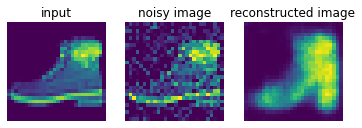

the training step and test evaluation took 26.53 seconds
train_loss 0.021382064
test_loss 0.020682646
1 . epoch --------------------------------------------------------------------------------


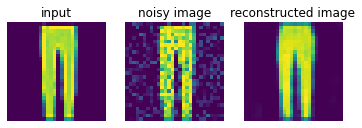

the training step and test evaluation took 24.22 seconds
train_loss 0.020330954
test_loss 0.02066075
2 . epoch --------------------------------------------------------------------------------


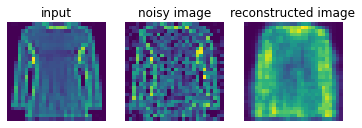

the training step and test evaluation took 24.68 seconds
train_loss 0.019507831
test_loss 0.019387662
3 . epoch --------------------------------------------------------------------------------


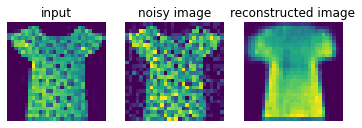

the training step and test evaluation took 24.88 seconds
train_loss 0.018976655
test_loss 0.0153106265
4 . epoch --------------------------------------------------------------------------------


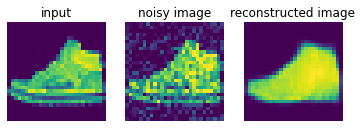

the training step and test evaluation took 24.34 seconds
train_loss 0.018512417
test_loss 0.020256832
5 . epoch --------------------------------------------------------------------------------


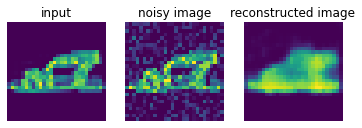

the training step and test evaluation took 24.84 seconds
train_loss 0.018143725
test_loss 0.018931096
6 . epoch --------------------------------------------------------------------------------


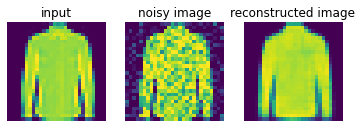

the training step and test evaluation took 24.18 seconds
train_loss 0.01786505
test_loss 0.015942037
7 . epoch --------------------------------------------------------------------------------


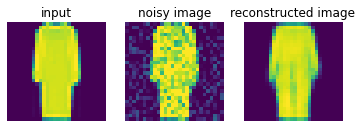

the training step and test evaluation took 24.53 seconds
train_loss 0.017668936
test_loss 0.015778499
8 . epoch --------------------------------------------------------------------------------


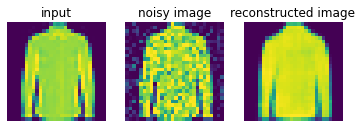

the training step and test evaluation took 24.5 seconds
train_loss 0.017473688
test_loss 0.017168446
9 . epoch --------------------------------------------------------------------------------


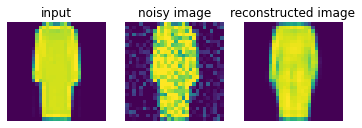

the training step and test evaluation took 24.32 seconds
train_loss 0.017292451
test_loss 0.014566117
10 . epoch --------------------------------------------------------------------------------


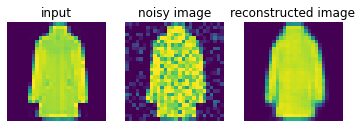

the training step and test evaluation took 24.91 seconds
train_loss 0.01716002
test_loss 0.015065149
11 . epoch --------------------------------------------------------------------------------


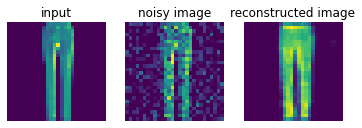

the training step and test evaluation took 24.58 seconds
train_loss 0.01702064
test_loss 0.014092564
12 . epoch --------------------------------------------------------------------------------


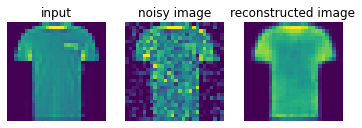

the training step and test evaluation took 24.61 seconds
train_loss 0.01690502
test_loss 0.017268104
13 . epoch --------------------------------------------------------------------------------


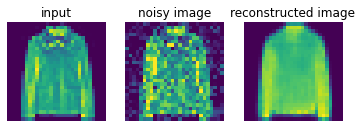

the training step and test evaluation took 24.85 seconds
train_loss 0.016790733
test_loss 0.016118545
14 . epoch --------------------------------------------------------------------------------


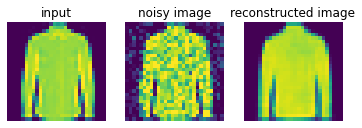

the training step and test evaluation took 24.5 seconds
train_loss 0.016689237
test_loss 0.017125648
15 . epoch --------------------------------------------------------------------------------


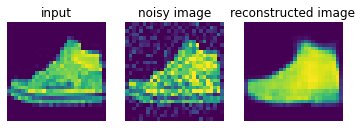

the training step and test evaluation took 24.91 seconds
train_loss 0.016582042
test_loss 0.014908959
16 . epoch --------------------------------------------------------------------------------


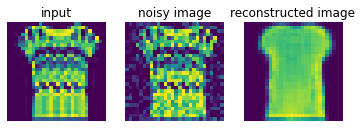

the training step and test evaluation took 24.75 seconds
train_loss 0.016475096
test_loss 0.012022829
17 . epoch --------------------------------------------------------------------------------


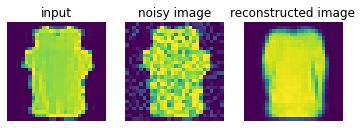

the training step and test evaluation took 23.94 seconds
train_loss 0.016381392
test_loss 0.019858375
18 . epoch --------------------------------------------------------------------------------


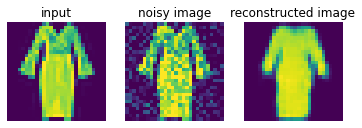

the training step and test evaluation took 24.87 seconds
train_loss 0.01631561
test_loss 0.013203391
19 . epoch --------------------------------------------------------------------------------


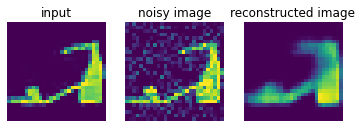

the training step and test evaluation took 24.07 seconds
train_loss 0.016226405
test_loss 0.014675022


In [10]:
tf.keras.backend.clear_session()

conv_ae = ConvoAE()

#Define hyperparameters
#How many training epochs do we perform
epochs = 20
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95


steps = []
train_losses = []
test_losses = []

for epoch in range(epochs):
  print(epoch, ". epoch --------------------------------------------------------------------------------")
  steps.append(epoch)


  start = time.time()
  original_loss = 0
  for images in training_data:

    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(images + 0.15 * noise, 0., 1.)

    train_loss = train_step(conv_ae, images, noisy_images , loss_function, optimizer, training = True)
    
    original_loss = running_average_factor * original_loss + (1-running_average_factor) * train_loss
  train_losses.append(original_loss)
  test_loss = test(conv_ae,test_data, loss_function)
  test_losses.append(test_loss)

  plot_img(training_data,conv_ae)

  print(f"the training step and test evaluation took {timing(start)} seconds")
  #some sort of plotting
  print("train_loss", np.mean(train_losses))
  print("test_loss", test_loss.numpy())

In [20]:
conv_ae.encoder.summary()
conv_ae.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_block (EncBlock)         multiple                  448       
_________________________________________________________________
enc_block_1 (EncBlock)       multiple                  4688      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7850      
Total params: 12,986
Trainable params: 12,890
Non-trainable params: 96
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  17248     
_____________________________________

## Latent Space Analysis

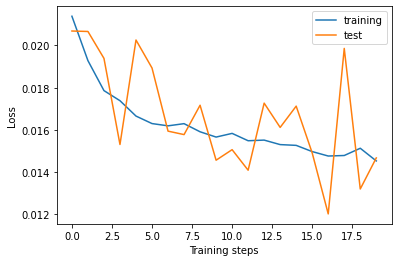

In [11]:
# plot losses
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

In [12]:
#TSNE stuff
from sklearn.manifold import TSNE

label_dict = {0: "tab:blue",1: "tab:green", 2: "tab:orange", 3: "tab:red", 4: "tab:purple",
               5: "tab:brown", 6: "tab:pink", 7: "tab:grey", 8: "tab:olive", 9: "tab:cyan"}

embeddings = []
#walk through the test_data and produce embeddings
#athe data is batched
for image in test_images_tsne:
  embeddings.append(conv_ae.encoder(image))

embeddings_arr = np.array(embeddings)
embeddings_arr = np.reshape(embeddings_arr, (1000,10))

embedded_label = test_labels



In [13]:
#Visualization
import matplotlib.colors as mcolors
def plot_embeddings(embeddings_arr ,embedded_label, perplexity):

  embeddings_arr = TSNE(n_components=2,perplexity = perplexity).fit_transform(embeddings_arr)
  embedded_x = embeddings_arr[:,0]
  embedded_y = embeddings_arr[:,1]

  fig, ax = plt.subplots()

  for x, y, group in zip(embedded_x, embedded_y, embedded_label):
    ax.scatter(x, y, c = label_dict[group], alpha = 0.5, s = 10)

  plt.xlabel("dimension 1")
  plt.ylabel("dimension 2")
  fig.suptitle("tsne perplexity = "+ str(perplexity))


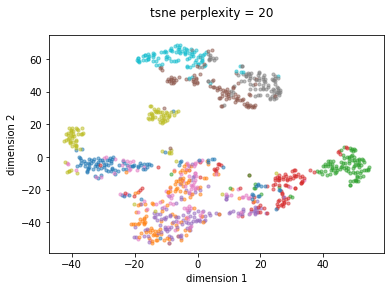

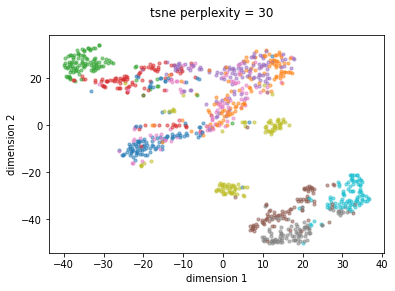

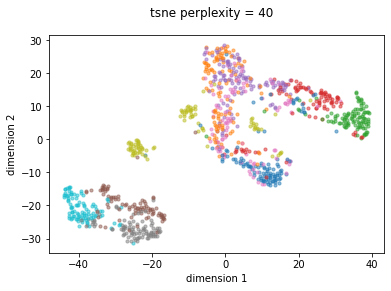

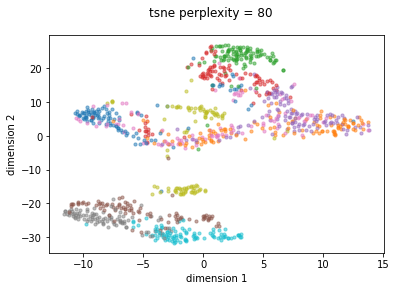

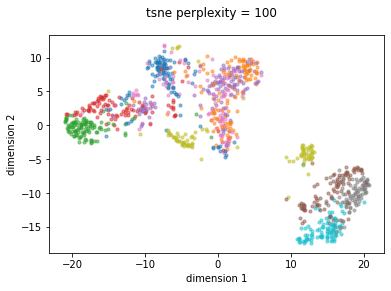

In [14]:

plot_embeddings(embeddings_arr, embedded_label, 20)
plot_embeddings(embeddings_arr, embedded_label, 30)
plot_embeddings(embeddings_arr, embedded_label, 40)
plot_embeddings(embeddings_arr, embedded_label, 80)
plot_embeddings(embeddings_arr, embedded_label, 100)


plt.show()

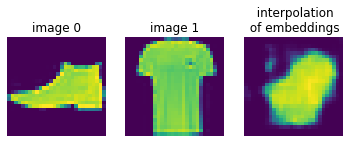

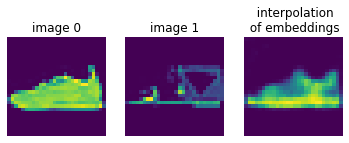

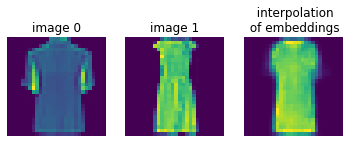

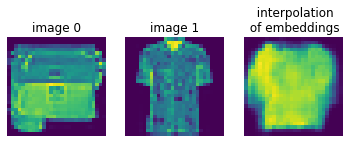

In [18]:
for _ in range(4):  
  images = []
  embeddings = []
  fig, ax = plt.subplots(1,3)

  for i, image in enumerate(training_data.take(2)):

    images.append(np.reshape(image[0].numpy(),(1,28,28,1)))
    embeddings.append(conv_ae.encoder(images[i], False))

    ax[i].imshow(tf.squeeze(images[i]))
    ax[i].set_title("image "+ str(i))
    ax[i].axis("off")

  interpol_emb = (embeddings[0] + embeddings[1])/2
  decoded_interpol = conv_ae.decoder(interpol_emb)

  ax[2].imshow(tf.squeeze(decoded_interpol))
  ax[2].set_title("  interpolation \n of embeddings")
  ax[2].axis("off")

  plt.show()

## Interpretation of the visualization of the embeddings
In t-SNE visualization of our embeddings we can see that our model differentiate some classes quite good, while other classes are to some extend mixed together. Also we can see that some classes are very close to each other, forming three two five global clusters. This makes sense, since for example sneakers, ankleboots and sandals are quite similar and therefore vuild their own cluster.

### Interpretation of the Interpolations
The interpolations between two images show quite good how the latend space ist structured:

similar classes are custered together, therefore interpolations between the two produce "sensible" outcomes. E.g. the picture laying between the t-shirt and the dress still looks like a light upper body clthing, while the interpolation between the t-shirt and the ankleboot lies somewhere in the latend space where the pictures do not make that much sense.